# Parametrizing a protein with a non-canonical amino acid for use in OpenMM

This is a working notebook to prompt discussion between Dennis Della Corte and Lily Wang.

It uses packages still under heavy development, namely:
* [fragmenter](https://github.com/openforcefield/fragmenter)
* [psiresp](https://github.com/lilyminium/psiresp)

For this notebook I modify a structure of [ubiquitin](https://www.rcsb.org/structure/1UBQ) to include L-Azidohomoalanine (AHA). I replace Ile13 with Aha13.



```
conda env create -f environment.yml
conda activate ncaa-openmm
jupyter-nbextension enable nglview --py --sys-prefix
python -m ipykernel install --user --name ncaa-openmm --display-name "Python (ncaa-openmm)"
```

In [1]:
# imports
import re
import numpy as np
import subprocess
from collections import defaultdict
import itertools
import copy

# chemical stuff
import simtk
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout
from rdkit import Chem
import MDAnalysis as mda
from openff.toolkit.topology import Molecule
import nglview as nv


# code currently in development
import psiresp as sip

## Adding the amino acid into the protein

Ubiquitin:

In [2]:
nv.show_file("1ubq.pdb")

NGLWidget()

AHA:

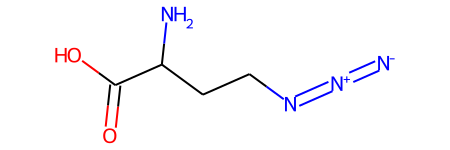

In [3]:
Chem.MolFromSmiles("C(CN=[N+]=[N-])C(C(=O)O)N")

In [4]:
from MDAnalysis.analysis import align

ubq = mda.Universe("1ubq.pdb")  # ubiquitin from PDB, run through pdb2gmx to add Hs
# get elements
ubq.add_TopologyAttr("elements")
ubq.atoms.types = [re.search(r"[A-Z]", a.name).group() for a in ubq.atoms]
ubq.atoms.elements = ubq.atoms.types
ubq.atoms.guess_bonds()
aha = mda.Universe("aha.mol2")  # aha, built by hand in IQMol. I like mol2 for including bond orders
aha.add_TopologyAttr("resnames")
aha.residues[0].resname = "AHA"
aha.segments[0].segid = "A"
# rename atoms for ease of reference
aha.atoms.names = [f"{x}{i}" for i, x in enumerate(aha.atoms.names, 1)]

# The N-CA-C=O atoms in aha are indices [0, 1, 2, 3]
# The N-CA-C=O atoms in Ile13 are indices [203, 205, 220, 221]
# align AHA to UBQ and replace Ile13
align.alignto(aha.atoms[[0, 1, 2, 3]], ubq.atoms[[203, 205, 220, 221]], match_atoms=False)
aha.residues.resids = 13

ubq_aha = mda.Merge(ubq.residues[:12].atoms, aha.atoms, ubq.residues[13:].atoms)
# add bonds connecting amino acid to those before and after
thr12c = ubq_aha.residues[11].atoms.select_atoms("name C")[0]
aha13 = ubq_aha.residues[12].atoms
thr14n = ubq_aha.residues[13].atoms.select_atoms("name N")[0]
bond1 = [thr12c.index, aha13.atoms[0].index]
bond2 = [aha13.atoms[2].index, thr14n.index]

ubq_aha.add_bonds([bond1, bond2])
ubq_aha.atoms.write("ubq_aha.pdb", bonds="all")

/Users/lily/anaconda3/envs/ncaa-openmm/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:864: DeprecationWarning: Using the last letter of the segid for the chainID is now deprecated and will be changed in 2.0. In 2.0, the chainID attribute will be used if it exists, or a placeholder value.
  "exists, or a placeholder value.", DeprecationWarning)


In [5]:
nv.show_mdanalysis(ubq_aha)

NGLWidget()

## Fail to parametrize with Amber14 in OpenMM

In [6]:
pdb = PDBFile('ubq_aha.pdb')
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml', "gaff-2.11.xml")
system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds)

ValueError: No template found for residue 13 (AHA).  The set of atoms is similar to ARG, but it is missing 9 atoms.

## Cap the non-canonical amino acid

### Cap with adjacent amino acids

In [7]:
def get_amino_acid_triplet(protein, resid=13):
    """Pick out the residue with the given residue number,
    and include the adjacent amino acids
    
    Parameters
    ----------
    protein: rdkit.Chem.Mol
    resid: int
    
    Returns
    -------
    rdkit.Chem.Mol
    """
    before = resid - 1
    after = resid + 1
    caps = [before, after]
    relevant = [before, resid, after]
    rdmol = Chem.RWMol(protein)
    to_delete = []
    for bond in rdmol.GetBonds():
        begin = bond.GetBeginAtom()
        end = bond.GetEndAtom()
        res_i = begin.GetMonomerInfo().GetResidueNumber()
        res_j = end.GetMonomerInfo().GetResidueNumber()
        if (res_i in caps and res_j not in relevant) or (res_j in caps and res_i not in relevant):
            to_delete.append((begin.GetIdx(), end.GetIdx()))
    for i, j in to_delete:
        rdmol.RemoveBond(i, j)
    mols = Chem.GetMolFrags(rdmol, asMols=True)
    for frag in mols:
        resnum = frag.GetAtomWithIdx(0).GetMonomerInfo().GetResidueNumber()
        if resnum in relevant:
            counter = 1
            Chem.AssignStereochemistryFrom3D(frag)
            for atom in frag.GetAtoms():
                if atom.GetMonomerInfo().GetResidueNumber() == resid:
                    atom.SetAtomMapNum(counter)
                    counter += 1
            Chem.SanitizeMol(frag)
            return frag
        

In [8]:
def map_mol2_onto_pdb_rdmol(rdmol, molfile, resid=13):
    """
    Map the connectivity of the amino acid read in from the molfile
    onto the given rdmol. Connectivity is changed in-place.
    
    As PDB files don't include bond order information,
    RDKit tends to assume everything is a single bond.
    
    Parameters
    ----------
    rdmol: rdkit.Chem.Mol
    molfile: str
        Filename in the mol/2 format.
    resid: int
        Residue number to re-fit connectivity for.
        
    """
    bond_mapping = {"1": Chem.BondType.SINGLE, "2": Chem.BondType.DOUBLE}
    u = mda.Universe(molfile)
    atom_mapping = {}
    counter = 0
    for atom in rdmol.GetAtoms():
        atom_resid = atom.GetMonomerInfo().GetResidueNumber()
        if atom_resid == resid:
            atom_mapping[counter] = atom.GetIdx()
            counter += 1
    for bond in u.atoms.bonds:
        i, j = map(int, bond.indices)
        order = bond.order
        pdb_bond = rdmol.GetBondBetweenAtoms(atom_mapping[i], atom_mapping[j])
        if pdb_bond is not None:
            if order in bond_mapping:
                pdb_bond.SetBondType(bond_mapping[order])
    rdmol.UpdatePropertyCache(strict=False)
    # clear up charges
    table = Chem.GetPeriodicTable()
    for i in atom_mapping.values():
        atom = rdmol.GetAtomWithIdx(i)
        expected = table.GetDefaultValence(atom.GetSymbol())
        observed = atom.GetExplicitValence()
        if observed != expected:
            atom.SetFormalCharge(observed - expected)
    Chem.SanitizeMol(rdmol)

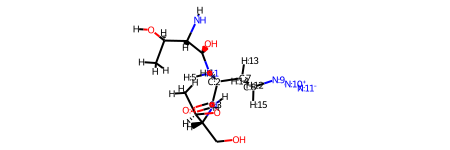

In [9]:
protein = Chem.MolFromPDBFile("ubq_aha.pdb", removeHs=False, proximityBonding=False)
map_mol2_onto_pdb_rdmol(protein, "aha.mol2", resid=13)
triplet = get_amino_acid_triplet(protein)
triplet

### Fragment so only relevant torsions etc are explored

In [10]:
# code still under development and liable to change
from fragmenter.fragment import WBOFragmenter

In [11]:
def fragment_molecule(fragmenter, rdmol, combine: bool=False, **kwargs):
    """Fragment an RDKit molecule using the fragmenter package.
    
    If ``combine=True``, this returns fragments by removing atoms
    from the original ``rdmol``. This means that atom mapping is
    conserved.
    
    Originally from https://github.com/lilyminium/cendol/
    """
    molecule = Molecule.from_rdkit(rdmol, allow_undefined_stereo=True)
    central = set()
    for atom in rdmol.GetAtoms():
        if atom.GetAtomMapNum() != 0:
            central.add(atom.GetIdx())
    fragger = fragmenter()
    results = fragger.fragment(molecule)
    fragments = []
    for (a1, a2), oemol in results.fragments_by_bond.items():
        if a1 in central or a2 in central:
            fragments.append(oemol)
    if not combine:
        if not fragments:
            return [rdmol]
        mols = [x.to_rdkit() for x in fragments]
        return mols
    # match all fragments to original molecule
    fragment_indices = set()
    for oemol in fragments:
        rdfrag = Chem.MolFromSmiles(oemol.smiles)
        rdfrag = Chem.AddHs(rdfrag)
        matches = rdmol.GetSubstructMatches(rdfrag)
        for m in matches:
            mset = set(m)
            if mset.intersection(central):
                fragment_indices |= mset
    atoms_to_keep = [i for i in range(rdmol.GetNumAtoms()) if i not in fragment_indices]
    rwmol = Chem.RWMol(rdmol)
    for idx in atoms_to_keep[::-1]:
        rwmol.RemoveAtom(idx)
    rwmol.UpdatePropertyCache()
    if not rwmol.GetNumAtoms():
        return [rdmol]
    Chem.SanitizeMol(rwmol)
    return [rwmol]

In [12]:
fragmented = fragment_molecule(WBOFragmenter,  # fragment by Wiberg Bond Order
                               triplet,  # RDKit molecule
                               combine=True,  # we want one fragment that includes the whole amino acid
                              )[0]  # only returns one fragment, get that

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 20)
 - Atom C (index 21)

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 22, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 40, aromatic: False, chiral: False



## Fitting charges with constraints

In [13]:
def get_forcefield_charge(forcefield, residue_name, atom_name):
    try:
        template = forcefield._templates[residue_name]
    except KeyError:
        return None
    for atom in template.atoms:
        if atom.name == atom_name:
            return atom.parameters["charge"]

In [14]:
def get_charge_constraints_from_rdmol(forcefield, topology, resname="AHA", molecular_charge=0):
    """
    Create charge constraints for PsiRESP from labelled RDKit molecule
    and existing charges in the force field.
    
    Parameters
    ----------
    forcefield: simtk.openmm.app.forcefield.ForceField
        Force field from which to obtain adjacent amino acid charges
    topology: simtk.openmm.app.topology.Topology
    resname: str
        Residue name
    molecular_charge: int (optional)
        Charge of the entire amino acid
    
        
    Returns
    -------
    psiresp.options.ChargeOptions
        Charge constraints for the RESP job
    """

    # unlabelled caps should sum to 0
    constraints = []
    cap_atoms = []
    relevant_indices = []
    for ommres in topology.residues():
        if ommres.name != resname:
            for atom in ommres.atoms():
                # constrain adjacent amino acids to have same charges
                # as in force field
                atom_charge = get_forcefield_charge(forcefield, ommres.name, atom.name)
                if atom_charge is not None:
                    constraints.append([atom_charge, [atom.index + 1]])
        else:
            for atom in ommres.atoms():
                relevant_indices.append(atom.index + 1)

    constraints.append([molecular_charge, relevant_indices])
    return sip.ChargeOptions(charge_constraints=constraints)

In [15]:
def run_resp(forcefield, topology, rdmol, executor=None, n_conformers=4, resname="Mol",
             rmsd_threshold=1.5, charge=0, multiplicity=1):
    """
    Run RESP with charge constraints
    
    Parameters
    ----------
    forcefield: simtk.openmm.app.forcefield.ForceField
        Force field from which to obtain adjacent amino acid charges
    topology: simtk.openmm.app.topology.Topology
    rdmol: rdkit.Chem.Mol
        The fragmented molecule for which to re-fit charges.
    executor: multiprocessing.Executor (optional)
        This is passed to PsiRESP for parallel processing.
    n_conformers: int (optional)
        Maximum number of conformers to automatically generate from the
        RDKit molecule. The actual number may be fewer depending on the
        RMSD threshold
    resname: str (optional)
        Name of the amino acid. This is also used for the job
    rmsd_threshold: float (optional)
        RMSD threshold for generating different conformers
    charge: int (optional)
        Overall molecular charge
    multiplicity: int (optional)
        Amino acid amino acid
    
        
    Returns
    -------
    numpy.ndarray
        Array of charges
    """
    charge_options = get_charge_constraints_from_rdmol(forcefield, topology, resname,
                                                       molecular_charge=charge)
    orientation_options = sip.OrientationOptions(n_reorientations=4)
#     print(charge_options)
    relevant_indices = [i for i, atom in enumerate(topology.atoms())
                        if atom.residue.name == resname]
    resp = sip.Resp.from_rdmol(rdmol, n_confs=1, name=resname,
                               rmsd_threshold=rmsd_threshold,
                               charge=charge, multiplicity=multiplicity,
                               orientation_options=orientation_options)
    print("Running RESP")
    charges = resp.run(charge_constraint_options=charge_options, stage_2=True,
                     hyp_a1=0.0005, hyp_a2=0.001, hyp_b=0.1,
                     restrained=True, ihfree=True, executor=executor)

    np.savetxt("all_charges.dat", charges)
    charges = resp.charges[relevant_indices]
    return charges

## Sticking it into the force field as a residue template

In [16]:
def run_antechamber(rdmol, name="mol", antechamber_path="/Users/lily/amber20/bin/antechamber"):
    """Run antechamber to get GAFF atom types and a mol2 file format out"""
    pdb = f"rdkit_{name}.pdb"
    mol2 = f"ante_{name}.mol2"
    Chem.MolToPDBFile(rdmol, pdb)
    print("Running antechamber")
    cmd = f"{antechamber_path} -i {pdb} -fi pdb -o {mol2} -fo mol2 -s 2"
    proc = subprocess.run(cmd, shell=True, stderr=subprocess.PIPE)
    u = mda.Universe(mol2)
    ommtop = PDBFile(pdb).topology
    return u, ommtop
    

def add_residue_template(rdmol, forcefield, executor=None, n_conformers=4,
                         charges=None, resname="AHA", charge=0, multiplicity=1):
    """
    Add a residue template for the non-canonical amino acid into the given force field.
    
    The force field is modified in place.
    
    Steps:
    1. Run antechamber to get GAFF atom types
    2. Fit charges with charge constraints to get an overall charge of ``charge``
    3. Add new atom types specifically for the new reisude and copy existing
       force parameters from the force field, to the new atom types
       
    Parameters
    ----------
    rdmol: rdkit.Chem.Mol
    forcefield: simtk.openmm.app.forcefield.ForceField
        Force field to modify
    executor: multiprocessing.Executor (optional)
        For running RESP in parallel, not sure how this works in a notebook
    n_conformers: int (optional)
        Max conformers to generate for RESP
    charges: iterable of floats (optional)
        If you run this repeatedly, you can load in charges because doing
        RESP over and over is pretty slow
    resname: str (optional)
        Residue name
    charge: int
        Overall amino acid charge
    multiplicity: int
        amino acid multiplicity
    """
    # this function will be a bit slow because of antechamber and RESP
    # first, cap unsatisfied valences with Hs
    only_on_atoms = [atom.GetIdx() for atom in rdmol.GetAtoms()
                     if atom.GetAtomMapNum() == 0]
    rdmol = Chem.AddHs(rdmol, addCoords=True, onlyOnAtoms=only_on_atoms)
    
    # I use antechamber here because, well, amber
    u, ommtop = run_antechamber(rdmol, name=resname)

    # then we get RESP charges, where the adjacent amino acid atoms
    # are constrained to the values given in the force field
    if charges is None:
        charges = run_resp(forcefield, ommtop, rdmol, executor=executor,
                           n_conformers=n_conformers, resname=resname,
                           charge=charge, multiplicity=multiplicity)
        np.savetxt("charges.dat", charges)

    # then we create a new template because OpenMM hates it when
    # we modify the old one?
    template = simtk.openmm.app.forcefield.ForceField._TemplateData(resname)
    mdares = u.select_atoms(f"resname {resname}").residues[0]
    
    # We copy all the atomtypes to a special new instance so that we
    # can modify those values in the force field specifically,
    # e.g. if we want to re-fit torsions
    atomtype_mapping = {}
    
    for i, mdatom in enumerate(mdares.atoms):
        # add it in as a new type
        atomtype = f"{resname}-{mdatom.name}"
        atomtype_mapping[atomtype] = mdatom.type
        forcefield.registerAtomType({"name": atomtype, "class": atomtype, "mass": mdatom.mass})
        
        symbol = rdmol.GetAtomWithIdx(int(mdatom.index)).GetSymbol()
        element = simtk.openmm.app.element.get_by_symbol(symbol)
        tmpatom = forcefield._TemplateAtomData(mdatom.name, atomtype, element)
        tmpatom.parameters["charge"] = charges[i]
        template.addAtom(tmpatom)
    
    # add in the bonds
    decrement = mdares.atoms[0].index
    resindices = mdares.atoms.indices - decrement
    for res in ommtop.residues():
        if res.name == template.name:
            for bond in res.bonds():
                i = bond.atom1.index - decrement
                j = bond.atom2.index - decrement
                if i in resindices and j in resindices:
                    template.addBond(i, j)
                else:
                    if i in resindices:
                        template.addExternalBond(i)
                    else:
                        template.addExternalBond(j)
    
    # register new atom types with copies of old forces
    register_new_atomtypes_from_copies_of_old(forcefield, atomtype_mapping)
    
    forcefield.registerResidueTemplate(template)
    return template


In [17]:
def add_to(default, key, value):
    """Helper function to add to a defaultdict"""
    existing = default[key]
    if isinstance(existing, set):
        default[key].add(value)
    else:
        default[key].append(value)

def add_new_combinations(force, foratomtype,
                         old_to_new, n_types=2,
                         parameters=[],
                         index_atomtypes=[0, 1]):
    """Helper function to add new forces to an openmm force field"""
    attrs = [f"types{i+1}" for i in range(n_types)]
    matches = set()
    for oldtype in old_to_new:
        matches |= set(foratomtype[oldtype])
    
    for i in matches:
        oldtypes = [getattr(force, attr)[i][0] for attr in attrs]
        newtypes = [old_to_new.get(old, [old]) for old in oldtypes]
        combinations = itertools.product(*newtypes)
        for group in combinations:
            index = len(force.types1)
            for j, (typeattr, newtype) in enumerate(zip(attrs, group)):
                if j in index_atomtypes:
                    add_to(foratomtype, newtype, index)
                getattr(force, typeattr).append([newtype])
            for param in parameters:
                param.append(param[i])
        

def register_new_atomtypes_from_copies_of_old(forcefield, atomtype_mapping):
    """Basically we just copy the force field entries for the old atomtypes
    and add them for the new ones too. Makes it easier to modify parameters
    for just this new amino acid down the line.
    
    The copying is done in-place.
    """
    old_to_new = defaultdict(list)
    for k, v in atomtype_mapping.items():
        old_to_new[v].append(k)
    for force in forcefield._forces:
        if isinstance(force, simtk.openmm.app.forcefield.HarmonicBondGenerator):
            add_new_combinations(force, force.bondsForAtomType,
                                 old_to_new, n_types=2,
                                 parameters=[force.k, force.length],
                                 index_atomtypes=[0, 1])
        elif isinstance(force, simtk.openmm.app.forcefield.HarmonicAngleGenerator):
            add_new_combinations(force, force.anglesForAtom2Type,
                                 old_to_new, n_types=3,
                                 parameters=[force.k, force.angle],
                                 index_atomtypes=[1])
        elif isinstance(force, simtk.openmm.app.forcefield.PeriodicTorsionGenerator):
            matches = set()
            for oldtype in old_to_new:
                matches |= force.propersForAtomType[oldtype]
            for i in matches:
                oldtypes = [force.proper[i].types2[0], force.proper[i].types3[0]]
                newtypes = [old_to_new.get(old, [old]) for old in oldtypes]
                combinations = itertools.product(*newtypes)
                for group in combinations:
                    index = len(force.proper)
                    copied = copy.deepcopy(force.proper[i])
                    copied.types2 = [group[0]]
                    copied.types3 = [group[1]]
                    force.propersForAtomType[group[0]].add(index)
                    force.propersForAtomType[group[1]].add(index)
                    force.proper.append(copied)
                
        elif isinstance(force, simtk.openmm.app.forcefield.NonbondedGenerator):
            for newtype, oldtype in atomtype_mapping.items():
                for attr in ["paramsForType", "extraParamsForType"]:
                    dct = getattr(force.params, attr)
                    if oldtype in dct:
                        dct[newtype] = dct[oldtype]
            

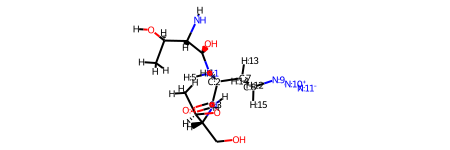

In [18]:
fragmented

In [19]:
pdb = PDBFile('ubq_aha.pdb')
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml', "gaff-2.11.xml")
charges = np.loadtxt("charges.dat")  # from when I ran add_residue_template earlier
# charges = None
add_residue_template(fragmented, forcefield, charges=charges, resname="AHA")

Running antechamber


In [20]:
system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME,
                                 nonbondedCutoff=1*nanometer, constraints=HBonds)